# DWPP test result analysis test code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pathlib import Path
import os



## Make reference path

In [2]:
def make_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    paths = []
    # 生成するカーブの角度パターン
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_segment = 3.0  # 直線区間の長さパラメータ

    for theta in theta_list:
        # 1. 直進 (0 -> 1m)
        x1 = np.linspace(0, 1, 100)
        y1 = np.zeros_like(x1)
        
        # 2. 斜め直線 (角度thetaで長さl)
        # Note: 実際には直線補間だが、ここでは簡易的に生成
        x2 = np.linspace(1.0, 1.0 + l_segment * math.cos(theta), 300)
        y2 = np.linspace(0.0, l_segment * math.sin(theta), 300)
        
        # 3. 終端直進 (さらに3m進む)
        x3 = np.linspace(
            1.0 + l_segment * math.cos(theta), 
            4.0 + l_segment * math.cos(theta), 300)
        y3 = np.ones_like(x3) * l_segment * math.sin(theta)

        # 結合
        xs = np.concatenate([x1, x2, x3])
        ys = np.concatenate([y1, y2, y3])
        
        path = np.c_[xs, ys]
        
        paths.append(path)
        

    # 展開して返す
    return (paths[0], paths[1], paths[2])

PathA, PathB, PathC = make_path()


## Function

In [3]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


In [4]:
def calc_violation_rate(violation_flags) -> float:
    violation_count = np.sum(violation_flags)
    total_count = len(violation_flags)
    violation_rate = violation_count / total_count
    return violation_rate

## Examine DWPP path test

[PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_APP_20251215_080001.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_DWPP_20251215_080143.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_PP_20251215_075859.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_RPP_20251215_080057.csv')]
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_APP_20251215_080001.csv
経路追従誤差RMSE (PathC): 0.2567 m
違反率: 0.4969
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_DWPP_20251215_080143.csv
経路追従誤差RMSE (PathC): 0.1379 m
違反率: 0.0000
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/Path C (135 deg)_PP_20251215_075859.csv
経路追従誤差RMSE (PathC): 0.3551 m
違反率: 0.5885

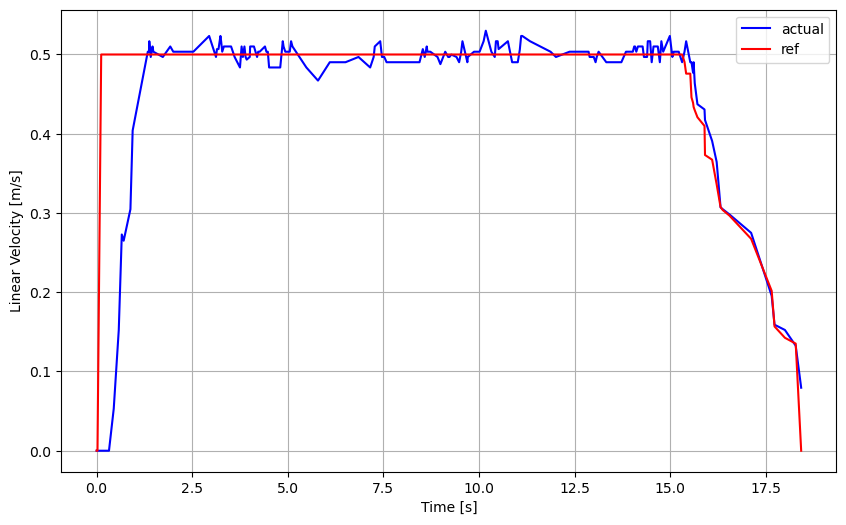

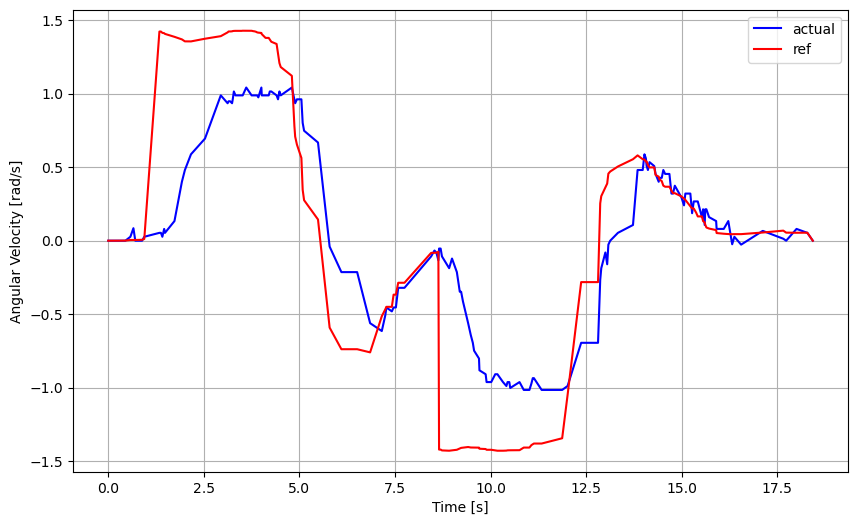

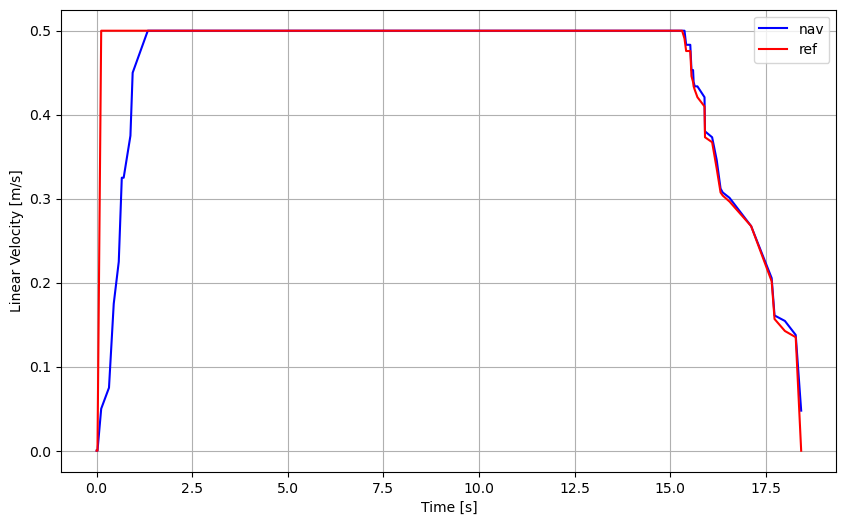

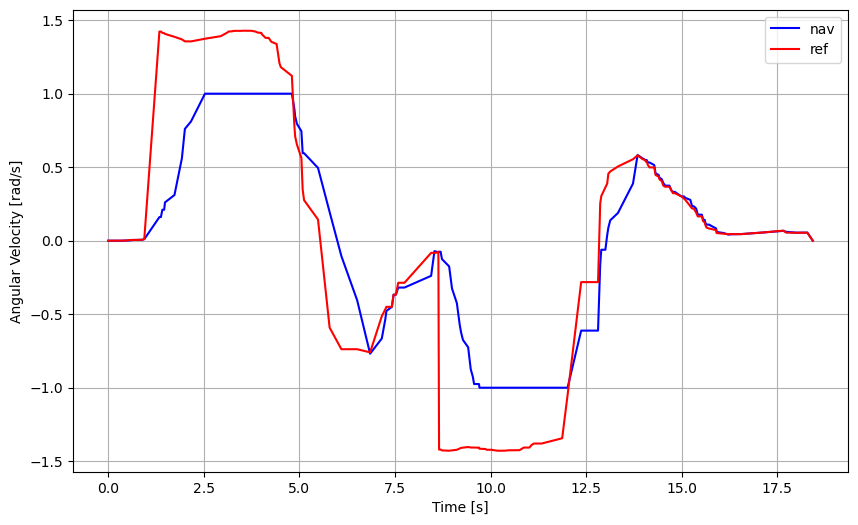

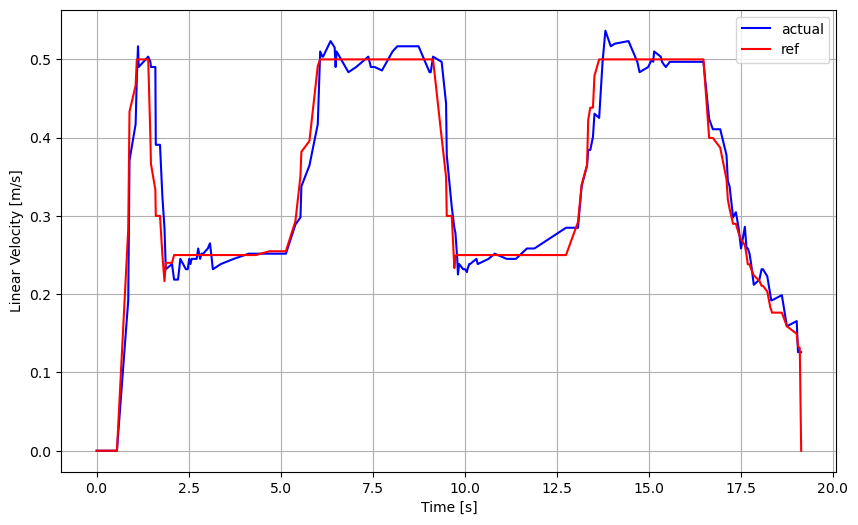

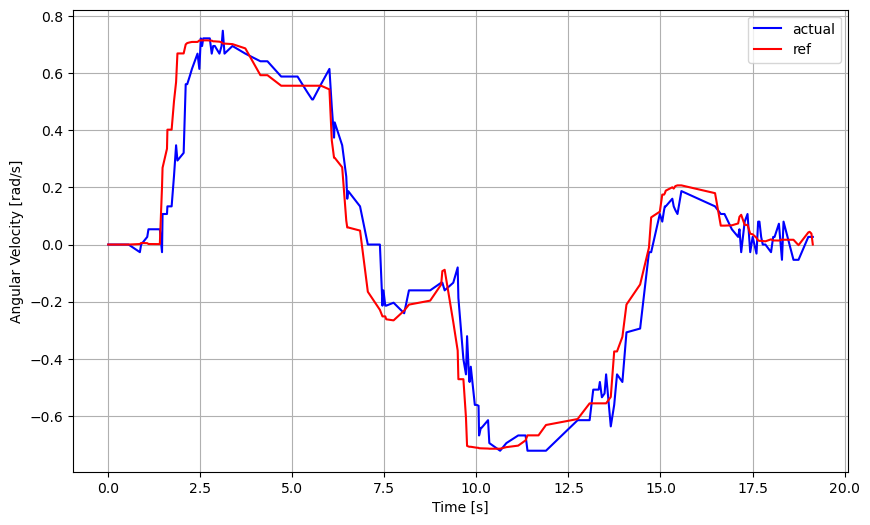

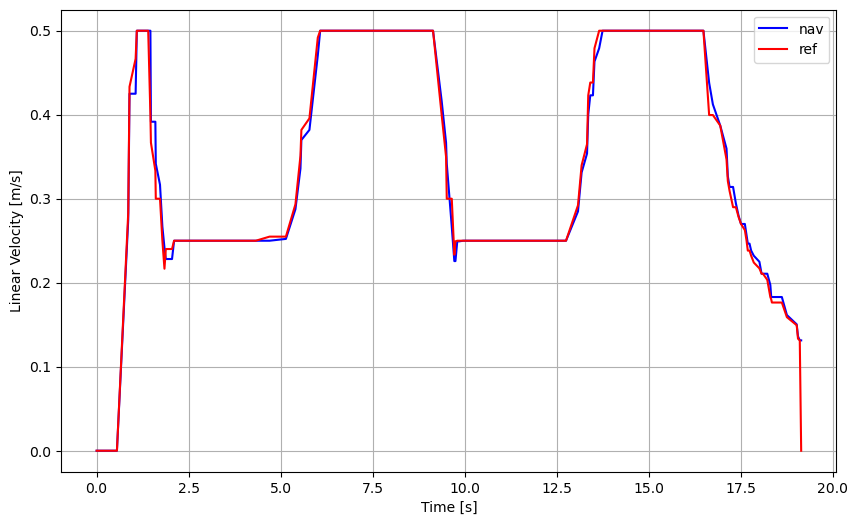

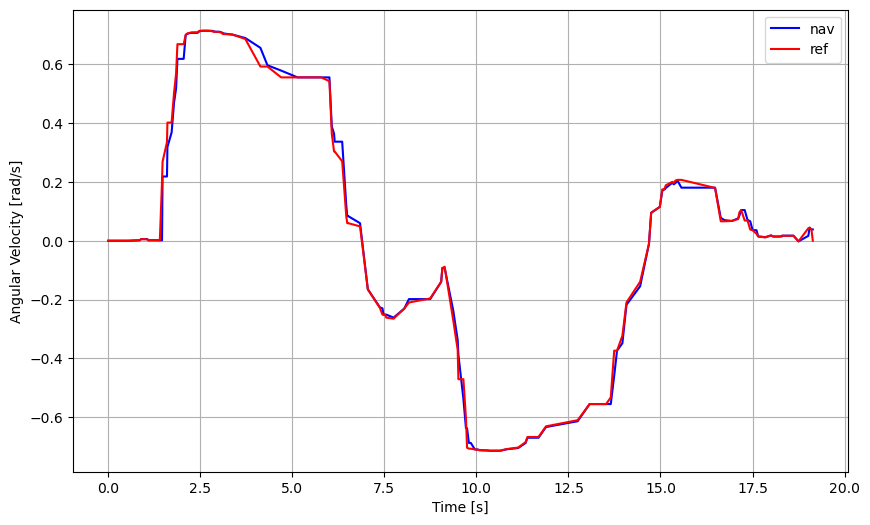

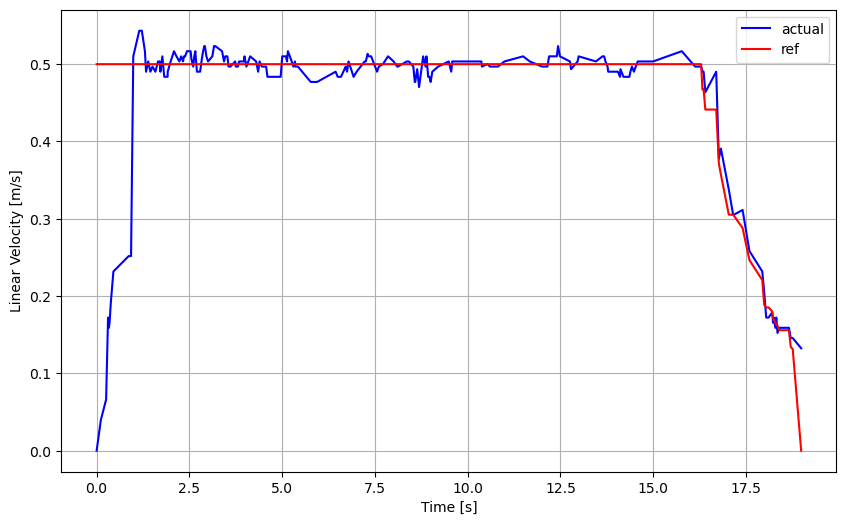

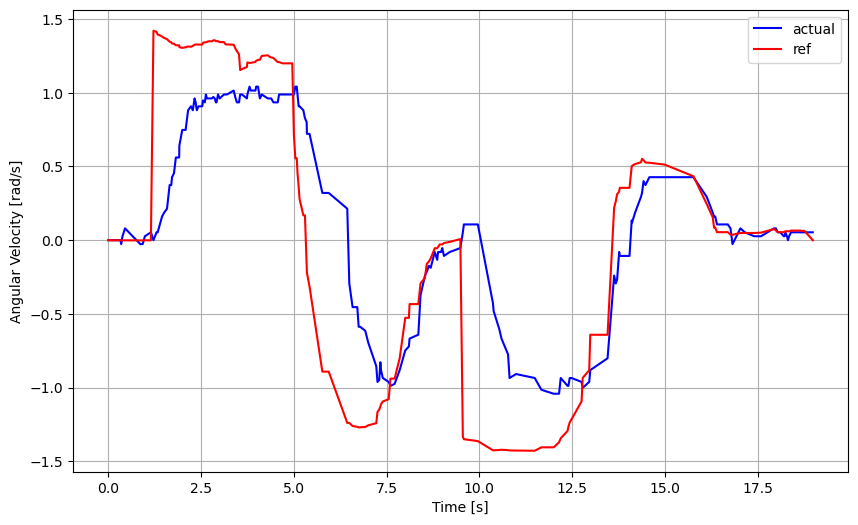

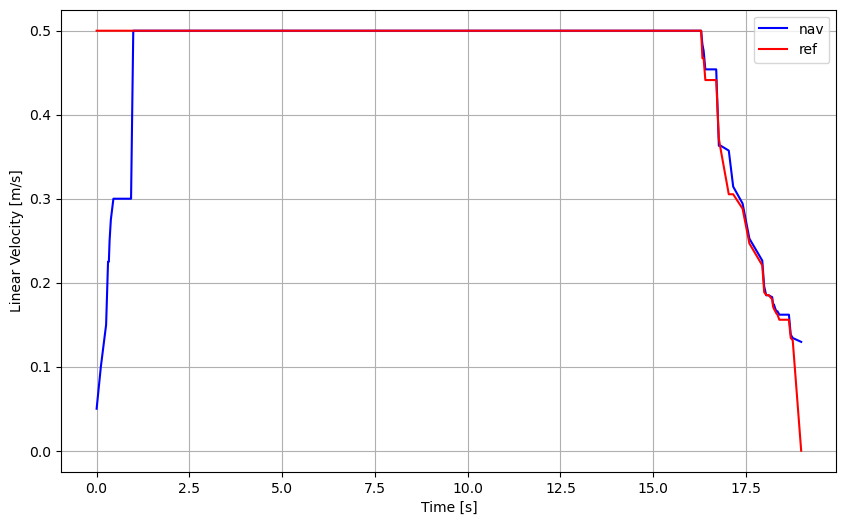

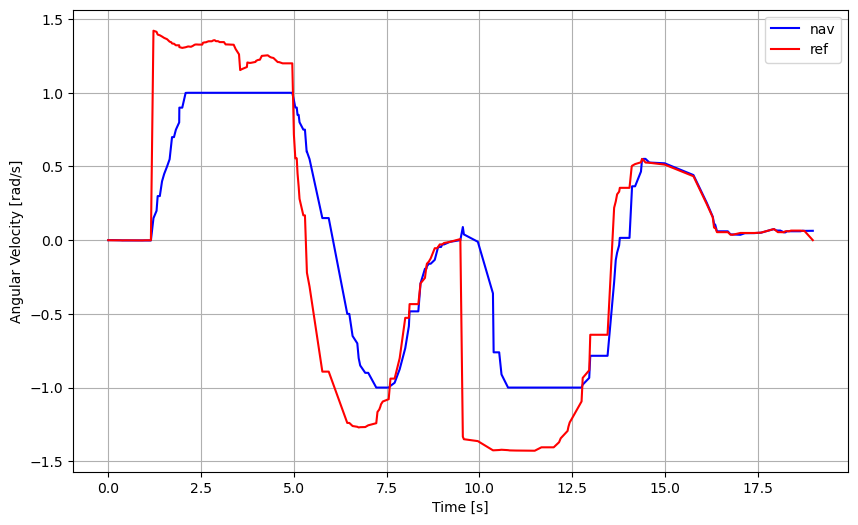

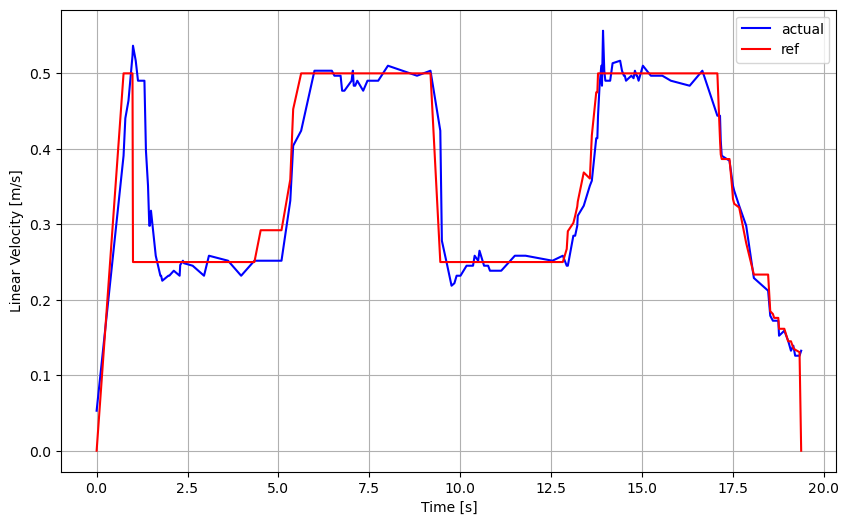

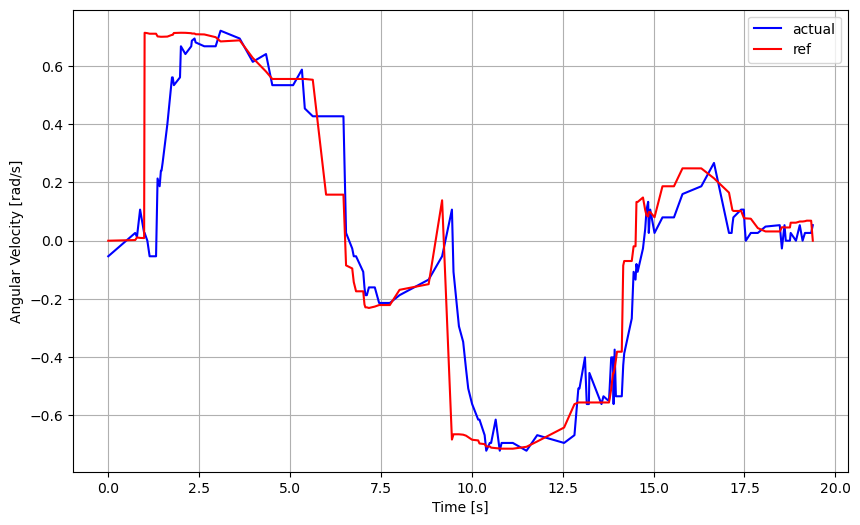

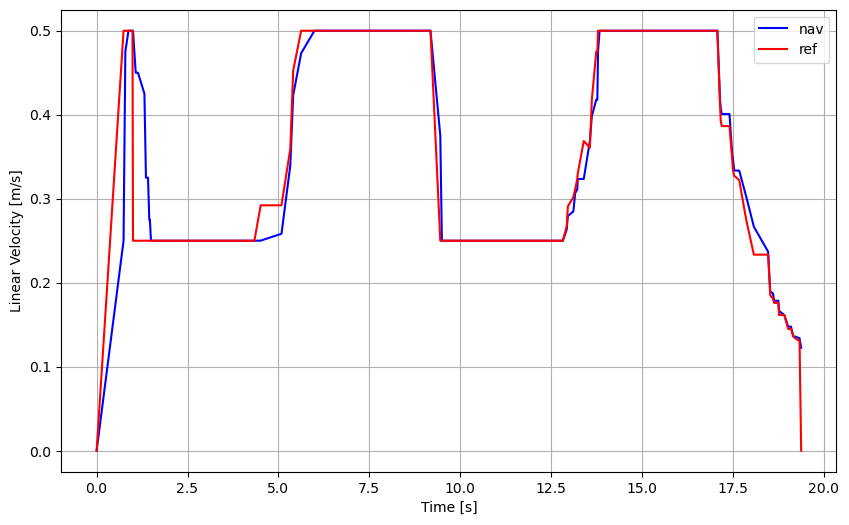

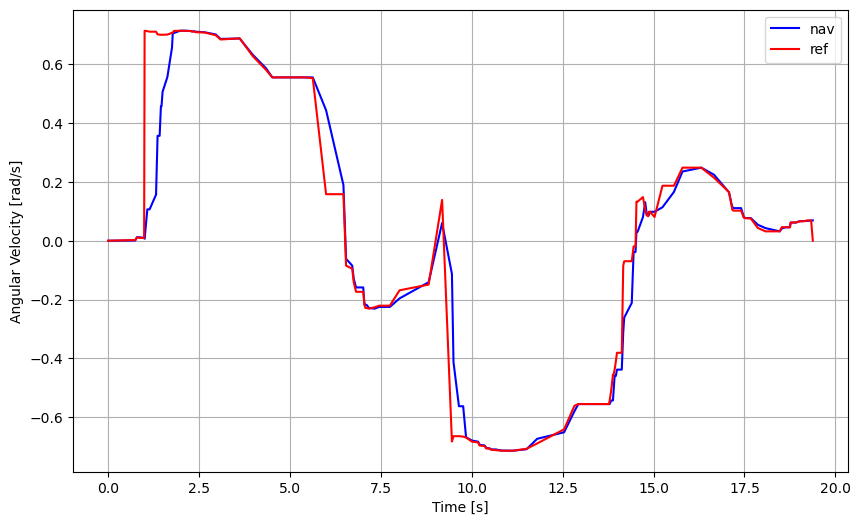

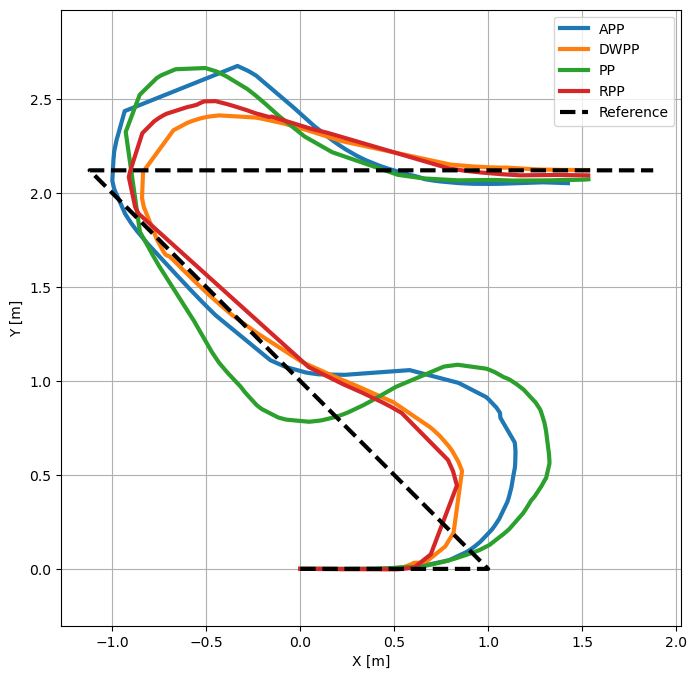

In [5]:
dir_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC")
data_paths = sorted(dir_path.glob("*.csv"))
method_list = ["APP", "DWPP", "PP", "RPP"]
path_dict = {
    "APP": None,
    "DWPP": None,
    "PP": None,
    "RPP": None}
print(data_paths)

for filepath, method_name in zip(data_paths, method_list):
    print("Processing file:", filepath)
    df = pd.read_csv(filepath)

    # データの読み込み
    t = df["sec"].values - df["sec"].values[0]  # 開始時間を0に合わせる
    x = df["x"].values
    y = df["y"].values
    robot_path = np.c_[x, y]
    path_dict[method_name] = robot_path
    v = df["v_real"].values
    w = df["w_real"].values
    cmd_v = df["v_cmd"].values
    cmd_w = df["w_cmd"].values
    v_nav = df["v_nav"].values
    w_nav = df["w_nav"].values
    velocity_violation_flag = df["velocity_violation"].values
    
    rmse = calc_rmse(robot_path, PathC)
    violation_rate = calc_violation_rate(velocity_violation_flag)
    print(f"経路追従誤差RMSE (PathC): {rmse:.4f} m")
    print(f"違反率: {violation_rate:.4f}")
    
    # txtに書き出し
    txt_filename = os.path.dirname(filepath) + "/result.txt"
    with open(txt_filename, "a") as f:
        f.write(f"Method: {method_name}\n")
        f.write(f"RMSE: {rmse:.4f} m\n")
        f.write(f"Violation Rate: {violation_rate:.4f}\n")
        f.write("\n")

    # 速度プロファイルの図示
    plt.figure(figsize=(10, 6))
    plt.plot(t, v, label="actual", color='blue')
    plt.plot(t, cmd_v, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Linear Velocity [m/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_real_v.png")

    plt.figure(figsize=(10, 6))
    plt.plot(t, w, label="actual", color='blue')
    plt.plot(t, cmd_w, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_real_w.png")
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, v_nav, label="nav", color='blue')
    plt.plot(t, cmd_v, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Linear Velocity [m/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_nav_v.png")

    plt.figure(figsize=(10, 6))
    plt.plot(t, w_nav, label="nav", color='blue')
    plt.plot(t, cmd_w, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_nav_w.png")

# 経路の描画
plt.figure(figsize=(8, 8))
for method_name in method_list:
    robot_path = path_dict[method_name]
    plt.plot(robot_path[:, 0], robot_path[:, 1], label=method_name, linewidth=3)
plt.plot(PathC[:, 0], PathC[:, 1], 'k--', label="Reference", linewidth=3)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.savefig(f"{dir_path}/path_comparison.png")

In [6]:
df.head()

,sec,nsec,x,y,yaw,v_real,w_real,v_cmd,w_cmd,v_nav,...,velocity_violation,battery_v,battery_i,battery_percent,imu_ax,imu_ay,imu_az,imu_vx,imu_vy,imu_vz
0,1.765753e+09,124613187,0.000000,0.000000e+00,0.000000,0.053000,-0.053428,0.0,0.000000,0.000,...,False,25.200001,-0.296,0.93,0.464475,0.301669,9.622296,0.003595,-0.013049,0.009321
1,1.765753e+09,865389775,0.000000,0.000000e+00,0.000000,0.390875,0.026713,0.5,0.002340,0.250,...,False,25.200001,-0.778,0.93,1.776498,-0.237026,10.757148,0.010519,-0.066579,-0.001065
2,1.765753e+09,914521195,0.000000,0.000000e+00,0.000000,0.440563,0.013357,0.5,0.011217,0.475,...,False,25.200001,-0.778,0.93,0.840365,-0.067038,10.826580,0.014381,-0.107325,-0.003196
3,1.765753e+09,224076,0.010467,4.777727e-07,0.000000,0.463750,0.106853,0.5,0.009677,0.500,...,False,25.200001,-0.778,0.93,2.116474,-0.265756,10.472238,-0.020639,0.056858,0.021039
4,1.765753e+09,111271579,0.018219,-1.654853e-06,-0.000267,0.523377,0.026718,0.5,0.009137,0.500,...,False,25.200001,-0.778,0.93,2.537854,0.337582,9.765949,-0.034621,0.010519,0.026765
